In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from IC.importer import *
from IC.processer import *
from IC.main import sim_events, list_of_params
from functions import ic_params_nsi,perform_chisq
from scipy.stats import chi2
from IC.event_processing import *
import pickle
from multiprocessing import Pool
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)

giunti_contour_cl90 = pd.read_csv('./src/data/files/giunti_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl90 = pd.read_csv('./src/data/files/ic_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
giunti_contour_cl99 = pd.read_csv('./src/data/files/giunti_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl99 = pd.read_csv('./src/data/files/ic_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
ic_34_cl90 = pd.read_csv('./src/data/files/ic_34_cl90.csv',header=None, names=['s24','s34']).sort_values('s34')
ic_34_cl99 = pd.read_csv('./src/data/files/ic_34_cl99.csv',header=None, names=['s24','s34']).sort_values('s34')


C:\Users\Martin\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [2]:
ndim = 3
N = 13
alpha = 0.99
precomputed_events = True
gamma=0
ic_params_nsi['dm_41'] = 0.93
ic_params['dm_41'] = 0.93
emm_range = np.array([0])#np.linspace(-1e-1,1e-1,30)
s24_range = np.array([0])#np.logspace(-2,np.log10(0.2),10)
emt_range = np.linspace(-1e-2,1e-2,100)
param_list = list_of_params_nsi(ic_params_nsi,s24_range, emm_range,emt_range)

#for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
#    assert is_precomputed_nsi(N=N,ndim=ndim, dict=p,check=False)


'''
param_list = return_precomputed_nsi(N,ndim,params=param_list)
emm_range = np.sort(np.unique(np.array([p['e_mm'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2
emt_range = np.sort(np.unique(np.array([p['e_mt'] for p in param_list])))

print(emm_range)
print(s24_range)
print(emt_range)
'''

"\nparam_list = return_precomputed_nsi(N,ndim,params=param_list)\nemm_range = np.sort(np.unique(np.array([p['e_mm'] for p in param_list])))\ns24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2\nemt_range = np.sort(np.unique(np.array([p['e_mt'] for p in param_list])))\n\nprint(emm_range)\nprint(s24_range)\nprint(emt_range)\n"

In [3]:
if not precomputed_events:
    print('Computing events')
    from multiprocessing import Pool
    p = Pool()
    data = [(alpha, N,p, False,False, [False, np.median(Ereco), gamma],True, True) for p in param_list]
    H1_events_list = p.starmap(sim_events, data)
    p.close()
    if len(emt_range) > 1:
        pickle.dump(H1_events_list,open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi.p','wb'))
    else:
        pickle.dump(H1_events_list,open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}_tau_nsi.p','wb'))

    H0_events = sim_events(alpha=alpha,npoints=N,params=ic_params, null=True, multi=False, spectral_shift=[False, np.median(Ereco), gamma],tau=True, nsi=True)
    pickle.dump(H0_events,open(f'./pre_computed/H0_N{N}_nsi_emt.p','wb'))
'''
if len(emt_range) > 1:
    H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi.p','rb'))
else:
    H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}_tau_nsi.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_N{N}_nsi.p','rb'))

'''
H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_N{N}_nsi.p','rb'))

gamma = 0.3
delta_T = (np.sum(sim_events(alpha=alpha,npoints=N,params=ic_params, null=True, multi=False, spectral_shift=[True, np.median(Ereco), gamma],tau=True, nsi=True)) - np.sum(H0_events))/np.sum(H0_events)

H0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,z_bins)

In [4]:
H0_normalized_z = np.sum(H0_normalized,axis=0)
H1_list_normalized_z = np.sum(np.array(H1_list_normalized),axis=1)

In [9]:
sigma_a = 0#.25
sigma_b = 0#.04
f = 0#.05
deltachi1, best_index, H1_chisq,H0_chisq = get_deltachi(H1_list_normalized, H0_normalized,emt_range,emm_range,delta_T,[sigma_a,sigma_b],f,x0=[1])
s24_cl90, s24_cl99, emm_cl90, emm_cl99 = get_contour(deltachi.T, emt_range,emm_range,2)
best_fit_coords = (param_list[best_index]['e_mt'], param_list[best_index]['e_mm'])

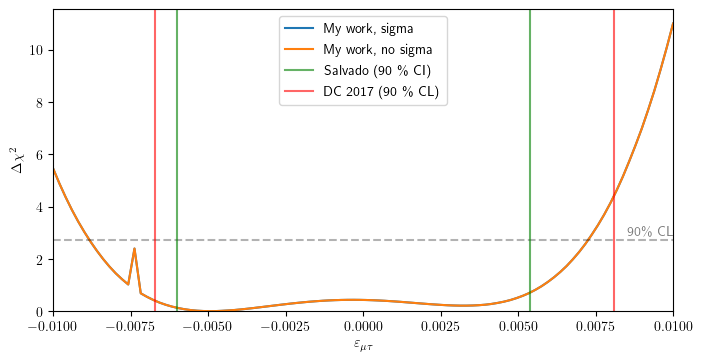

In [10]:
salvado = (-6e-3, 5.4e-3)
dc_2017 = (-6.7e-3, 8.1e-3)
plt.plot(emt_range, deltachi,label='My work, sigma')
plt.plot(emt_range, deltachi1,label='My work, no sigma')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(salvado[0], alpha=0.6,c='green', label='Salvado (90 \% CI)')
plt.axvline(dc_2017[0], alpha=0.6,c='red', label='DC 2017 (90 \% CL)')
plt.axvline(dc_2017[1], alpha=0.6,c='red')
plt.axvline(salvado[1], alpha=0.6,c='green')
plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
plt.xlim((emt_range.min(), emt_range.max()))
plt.xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=10)
plt.ylabel(r'$\Delta \chi^2$', fontsize=10)
plt.legend()

In [15]:
#s24_cl90_emt, s24_cl99_emt, emm_cl90_emt, emm_cl99_emt= s24_cl90, s24_cl99, emm_cl90, emm_cl99
s24_cl90_emm, s24_cl99_emm, emm_cl90_emm, emm_cl99_emm= s24_cl90, s24_cl99, emm_cl90, emm_cl99

Text(0.05, 0.65, '$\\pi_N = 0.25$\n$\\pi_\\theta = 0.04$\n$\\Delta \\gamma = 0.3$\n$f = 0.1$\n')

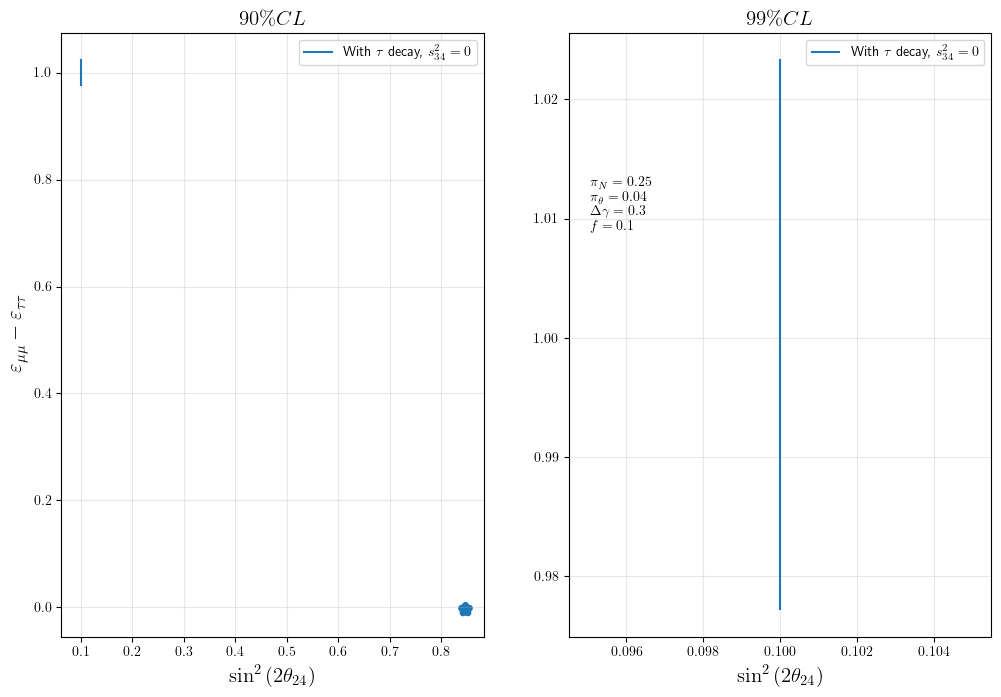

In [18]:
fig,ax = plt.subplots(1,2,figsize=(12,8))


#ax[0].plot(s24_cl90_emt, emm_cl90_emt, label=r'With $\tau$ decay, $s_{34}^2=0$ ')
ax[0].plot(s24_cl90_emm, emm_cl90_emm, label=r'With $\tau$ decay, $s_{34}^2=0$ ')


#ax[1].plot(s24_cl99_emt, emm_cl99_emt, label=r'With $\tau$ decay, $s_{34}^2=0$ ')
ax[1].plot(s24_cl99_emm, emm_cl99_emm, label=r'With $\tau$ decay, $s_{34}^2=0$ ')
#ax[0].scatter(best_fit_coords[0],best_fit_coords[1], marker='*', lw=5)
#ax[0].set_xscale('log')
#ax[1].set_xscale('log')
#ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[0].set_xlim((s24_range.min(), s24_range.max()))
#ax[1].set_xlim((s24_range.min(), s24_range.max()))
#ax[0].set_ylim((emm_range.min(),emm_range.max()))
#ax[1].set_ylim((emm_range.min(),emm_range.max()))
ax[0].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=15)
ax[1].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=15)
ax[0].set_ylabel(r'$\varepsilon_{\mu\mu} - \varepsilon_{\tau\tau}$', fontsize=15)
ax[0].grid(True, which='both', alpha=0.3)
ax[1].grid(True, which='both', alpha=0.3)
ax[0].set_title(r'$90\% CL$', fontsize=15)
ax[1].set_title(r'$99\% CL$', fontsize=15)

ax[0].legend()
ax[1].legend()
plt.annotate(f'$\pi_N = {sigma_a}$\n$\pi_\\theta = {sigma_b}$\n$\Delta \gamma = {gamma}$\n$f = {f}$\n', 
        xy=(0.05, 0.65), xycoords='axes fraction')
#plt.plot(best_fit_coords[0], best_fit_coords[1], marker='o', color='black')

In [27]:
# Plots for Smirnov 2013
from plotter import P_over_E_parameter
ic_params_nsi['dm_41'] = 0.93
ndim = 3
E = np.logspace(np.log10(500),4,50)
plot_params = list_of_params_nsi(ic_params_nsi, emm_range=np.array([0.06]),emt_range= np.array([-0.01,0,0.01]), s24_range=np.array([0]))
Pam = P_over_E_parameter('m', param_dict_list=plot_params, E=E, zenith = -1, ndim = ndim, anti=True, nsi=True)
Pm = P_over_E_parameter('m', param_dict_list=plot_params, E=E, zenith =-1, ndim = ndim, anti=False, nsi=True)
Pe = P_over_E_parameter('e', param_dict_list=plot_params, E=E, zenith = -1, ndim = ndim, anti=False, nsi=True)
Pae = P_over_E_parameter('e', param_dict_list=plot_params, E=E, zenith = -1, ndim = ndim, anti=True, nsi=True)

Pamam = Pam[:,1]
Pamat = Pam[:,2]
Pmm = Pm[:,1]
Pmt = Pm[:,2]
Pem = Pe[:,1]
Paeam = Pae[:,1]

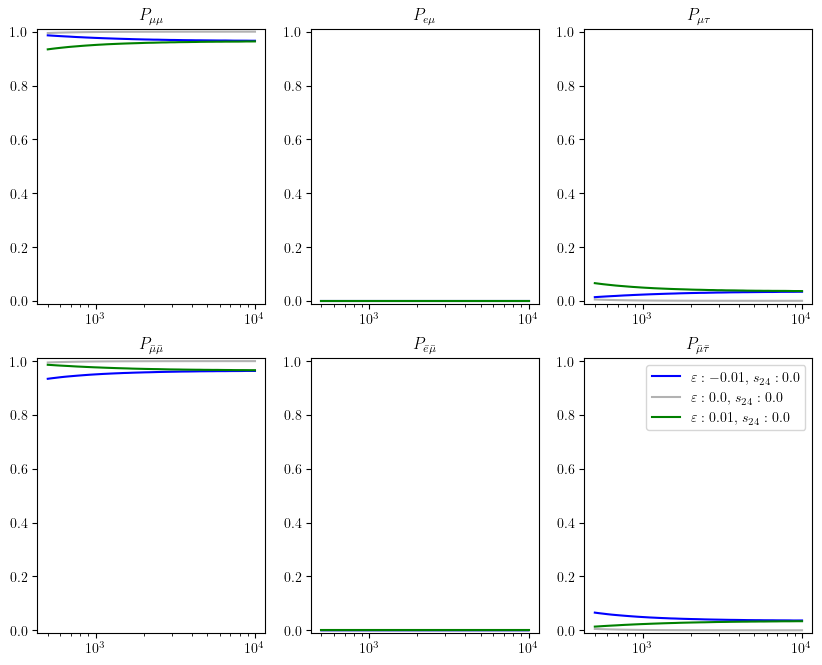

In [28]:
fig, ax = plt.subplots(2,3, figsize=(10,8))
ax = ax.flatten()
colors = ['blue','black','green']
alpha = [1,0.3,1]
for i,prob in enumerate(Pmm):
    ax[0].plot(E, prob, c=colors[i], alpha=alpha[i],label=f'$\\varepsilon: {np.round(plot_params[i]["e_mt"],3)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')

for i,prob in enumerate(Pem):
    ax[1].plot(E, prob, c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mt"],3)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')
for i,prob in enumerate(Pmt):
    ax[2].plot(E, prob, c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mt"],3)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')
for i,prob in enumerate(Pamam):
    ax[3].plot(E, prob,c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mt"],3)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')
for i,prob in enumerate(Paeam):
    ax[4].plot(E, prob,c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mt"],3)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')
for i,prob in enumerate(Pamat):
    ax[5].plot(E, prob,c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mt"],3)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[4].set_xscale('log')
ax[5].set_xscale('log')
ax[0].set_ylim((-0.01,1.01))
ax[1].set_ylim((-0.01,1.01))
ax[2].set_ylim((-0.01,1.01))
ax[3].set_ylim((-0.01,1.01))
ax[4].set_ylim((-0.01,1.01))
ax[5].set_ylim((-0.01,1.01))
ax[0].set_title('$P_{\mu\mu}$')
ax[1].set_title('$P_{e\mu}$')
ax[2].set_title('$P_{\mu\\tau}$')
ax[3].set_title('$P_{\\bar{\mu}\\bar{\mu}}$')
ax[4].set_title('$P_{\\bar{e}\\bar{\mu}}$')
ax[5].set_title('$P_{\\bar{\mu}\\bar{\\tau}}$')
plt.legend()